# Data Wrangling with Spark
<p>We are going to work with data from a realistic digital music service similar to Spotify where many users stream songs every day. Users can cancel their service at any time. So it's crucial to make sure users love the service.</p>
<p>Predicting churn rates is a challenging and common problem regularly encountered in customer-facing businesses. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.</p>
<p>In this article, we'll learn to manipulate large datasets with Spark to engineer relevant features for prediction. We'll use Spark because it is capable of far beyond what could be done with non-distributed technologies like scikit-learn for Big Data.</p>

In [1]:
# Importing libraries
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade matplotlib
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import*
from pyspark.sql.functions import*
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg as Favg

Requirement already up-to-date: matplotlib in /opt/conda/lib/python3.6/site-packages (3.3.4)


In [2]:
# creating a Spark session
spark = SparkSession.builder.appName("Spark SQL").getOrCreate()

## Loading the Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

In [3]:
# the IP address of the master node
path = "mini_sparkify_event_data.json"

In [4]:
# loading the json file into a spark DataFrame
user_log = spark.read.json(path)

## Data Exploration 

In [5]:
# Seeing the columns in this dataframe
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



There are fields describing the user like firstName, lastName and userId. We also have information about the request, for example, the page the user accessed, the HTTP method, and the status of the request.

In [7]:
# looking at one particular record
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

Here we can see that Colin was listening to "Rockpools"

In [8]:
# Looking at the first 5 records
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

<p>Every time the user interacts with the service it generates data that contains the key insights for keeping users happy and helping the business thrive.</p>
<p>The full dataset that contains the events is 12GB and is available on AWS, we will analyze a mini subset but we can choose to deploy a Spark cluster on the cloud using a cloud service.</p>

In [9]:
# Summary statistics on the length column which reffers to the lenght of each action in seconds
user_log.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [10]:
print("We have {} rows on the dataset".format(user_log.count()))

We have 286500 rows on the dataset


In [11]:
# Looking at the possible page requests for users
user_log.select("page").dropDuplicates().sort("page").show(25)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Users can login and out, visit the homepage, or play a song.

In [12]:
user_log.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



We have two subscriptions levels, the free-tier place advertisements between the songs and the paid model.

In [13]:
# Looking at the events of userId 30
user_log.select(["userId", "firstName", "page", "song"]).filter(user_log.userId == "30").head(10)

[Row(userId='30', firstName='Colin', page='NextSong', song='Rockpools'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Time For Miracles'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userId='30', firstName='Colin', page='Add to Playlist', song=None),
 Row(userId='30', firstName='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Jade'),
 Row(userId='30', firstName='Colin', page='NextSong', song='So-Called Friends'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Represent'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Here I Am')]

As users use different pages of the application, their page request are logged

## Checking for invalid or missing data

In [14]:
# Dropping missing values
user_log_valid = user_log.dropna(how="any", subset=["userId", "sessionId"])

In [15]:
# Making sure that we have the userId and SessionId for all the records
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



There are not None values but there are users with no userId

In [16]:
# Looking at logs of users with no userId
user_log.select(["userId", "firstName", "page", "song", "auth"]).filter(user_log.userId == "").head(5)

[Row(userId='', firstName=None, page='Home', song=None, auth='Logged Out'),
 Row(userId='', firstName=None, page='Help', song=None, auth='Logged Out'),
 Row(userId='', firstName=None, page='Home', song=None, auth='Logged Out'),
 Row(userId='', firstName=None, page='Login', song=None, auth='Logged Out'),
 Row(userId='', firstName=None, page='Home', song=None, auth='Logged Out')]

In [17]:
# filter for users with blank user id
blank_pages = user_log.filter(user_log.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

blank_pages.collect()

[Row(blank_pages='Home'),
 Row(blank_pages='About'),
 Row(blank_pages='Submit Registration'),
 Row(blank_pages='Login'),
 Row(blank_pages='Register'),
 Row(blank_pages='Help'),
 Row(blank_pages='Error')]

It seems that the user's with no id represent users who have not signed up yet or who logged out.
It may also represents users who got an error while registrating or loging in.

In [18]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [19]:
user_log_valid.count()

278154

In [20]:
print("We lost {} records".format(user_log.count() - user_log_valid.count()))

We lost 8346 records


In [21]:
female_users = user_log_valid.filter(user_log_valid.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

male_users = user_log_valid.filter(user_log_valid.gender == 'M') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

In [22]:
print("We have {} female users and {} male users".format(female_users, male_users))

We have 104 female users and 121 male users


How many songs were played from the most played artist?

In [23]:
user_log_valid.filter(user_log_valid.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+-------------+-----------+
|       Artist|Artistcount|
+-------------+-----------+
|Kings Of Leon|       1841|
+-------------+-----------+
only showing top 1 row



## Defining Churn as Users Who Cancel Their Accounts
<p>Let's predict which users are at risk of canceling their service. If we can accurately identify these users before they leave, we can then test strategies on them to potentially save millions in revenue.</p>
<p>We will load, explore and clean the dataset with Spark. Based on this exploration, We'll create features and build models with Spark to predict which users canceled from the digital music service.</p>

Creating a Churn column which divides the users who have confirm a cancellation to use as the label of the model.

In [24]:
# flagging users who have an event called "Cancellation Confirmation" to distinguish each 
# user's data as either pre or post churn events
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Adding a new column called Churn_phase to our dataframe
user_log_valid = user_log_valid.withColumn("Churn_phase", flag_churn_event("page"))

In [25]:
# Adding a new column called Churn to the dataframe. The value here will be 1 if the user 
# cancelled, and zero other wise
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# Creating a Churn column that uses the window function and cumulative sum
user_log_valid = user_log_valid.withColumn('Churn', Fsum('Churn_phase').over(windowval))

In [26]:
user_log_valid.select(["userId", "firstname", "ts", "page", "Churn", "Churn_phase"]) \
    .filter(user_log_valid.userId == "100014").sort(desc("ts")).head(5)

[Row(userId='100014', firstname='Rodrigo', ts=1542740649000, page='Cancellation Confirmation', Churn=1, Churn_phase=1),
 Row(userId='100014', firstname='Rodrigo', ts=1542740642000, page='Cancel', Churn=1, Churn_phase=0),
 Row(userId='100014', firstname='Rodrigo', ts=1542740641000, page='Downgrade', Churn=1, Churn_phase=0),
 Row(userId='100014', firstname='Rodrigo', ts=1542740628000, page='NextSong', Churn=1, Churn_phase=0),
 Row(userId='100014', firstname='Rodrigo', ts=1542740352000, page='NextSong', Churn=1, Churn_phase=0)]

After the Cancellation Confirmation we no longer see logs from Rodrigo

In [27]:
user_log_valid.select("userId", "Churn").dropDuplicates().groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



Since the churned users are a fairly small subset, we will be using the F1 score as the metric to optimize. Also, we'll use stratified sampling with two strata, one for Retained users and the other for Churned users. This is to guarantee that the train and test set is representative of the overall population in terms of the percent of Churned and Retained users in the dataset.

In [28]:
# Defining the target labels
labels = user_log_valid.select("userId", "Churn").dropDuplicates()

# setting the seed
seed = 42
# Sampling the data with roughly 75% of the Churned and Retained users
fractions = labels.select("Churn").distinct().withColumn("fraction", lit(0.747)).rdd.collectAsMap()
train_ids = labels.stat.sampleBy("Churn", fractions, seed)
train_ids = train_ids.drop("Churn")

In [29]:
train = user_log_valid.join(train_ids, on="userId", how="inner")
test = user_log_valid.join(train_ids, on="userId", how="leftanti")

## EDA on the Training Data
Now that we have taken a quick glance at the data and defined the target labels, let's set aside the test data to avoid data snooping bias. If we estimate the generalization error using the test set, our estimate will be too optimistic, and the launched system will not perform as well as expected.

Let's perform some exploratory data analysis on the training data to observe the behavior for users who stayed vs users who canceled their service.

### Exploring aggregates on these two groups of users

In [30]:
## Plotting in a histogram the distinct artist that are listened by churn users and retained users

artist_per_user = train.filter(train.Churn == 0).groupby(train.userId, train.artist) \
    .count()
artist_per_user_pd = artist_per_user.toPandas()
artist_per_user_pd = artist_per_user_pd[~artist_per_user_pd['artist'].isnull()]
artist_per_user_pd = artist_per_user_pd.groupby('userId').count().drop("count", axis=1)

artist_per_user_churn = train.filter(train.Churn == 1) \
    .groupby(train.userId, train.artist).count()
artist_per_user_churn_pd = artist_per_user_churn.toPandas()
artist_per_user_churn_pd = artist_per_user_churn_pd[~artist_per_user_churn_pd['artist'].isnull()]
artist_per_user_churn_pd = artist_per_user_churn_pd.groupby('userId').count().drop("count", axis=1)

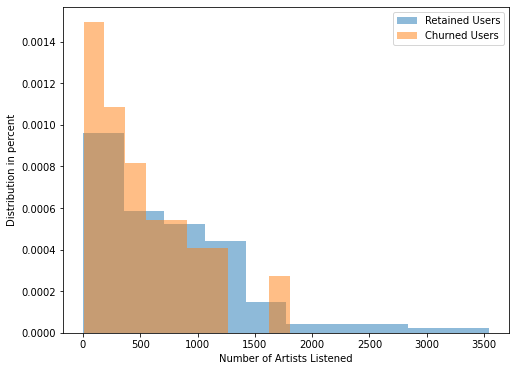

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(artist_per_user_pd["artist"], density=True, label="Retained Users", alpha=0.5);
plt.hist(artist_per_user_churn_pd["artist"], density=True, label="Churned Users", alpha=0.5);
plt.xlabel("Number of Artists Listened");
plt.ylabel("Distribution in percent");
plt.legend();

We can notice from this histogram that Retained Users tend to listen to a higher number of artists compared to Churned users

In [32]:
# Calculating the percent of each page visited for Retained Users
page_percent = train.filter(train.Churn == 0).groupBy('page').count() \
    .withColumn('Percent_Retained_Users', col('count')/sum('count').over(Window.partitionBy())).select(["page", "Percent_Retained_Users"])
page_percent = page_percent.toPandas()

# Calculating the percent of each page visited for Churned Users
page_percent_churn = train.filter(train.Churn == 1).groupBy('page').count() \
    .withColumn('Percent_Churned_Users', col('count')/sum('count').over(Window.partitionBy())) \
    .select(["page", "Percent_Churned_Users"])
page_percent_churn = page_percent_churn.toPandas()

In [33]:
# Merging the Retained and Churned Users table of the percent of each page visited
page_percent_comparison = page_percent.merge(page_percent_churn, on='page')
# Creating a column called Diff to compare where do both groups differ the most
page_percent_comparison['Diff'] = (page_percent_comparison['Percent_Retained_Users'] - page_percent_comparison['Percent_Churned_Users']) \
    .abs()
# Sorting the table by descending order from the Diff column
page_percent_comparison.sort_values('Diff', ascending=False)

,page,Percent_Retained_Users,Percent_Churned_Users,Diff
12,Thumbs Up,0.046616,0.040106,0.006510
4,Roll Advert,0.013632,0.019113,0.005480
11,NextSong,0.819859,0.814684,0.005175
1,Thumbs Down,0.008885,0.011310,0.002425
10,Add Friend,0.015653,0.014454,0.001199
2,Home,0.036172,0.037243,0.001071
3,Downgrade,0.007223,0.008027,0.000803
7,About,0.001857,0.001235,0.000623
5,Logout,0.011498,0.012068,0.000570
14,Upgrade,0.001776,0.002273,0.000497


Looking at this table of the pages visited by Retained and Churned users, sorted by highest difference between these groups, we can notice that the thumbs up and down ratio can be promising features for the ML algorithms. The number of Ads (Roll Advert) or Songs played (NextSong) per a certain time unit also look promising.

### Observing how much of a specific action they experienced per a certain time unit

Let's convert the timestamp to the common date format to compare how much of a specific action they experienced per a certain time unit

In [34]:
# Converting timestamps to datetime from epoch time, to get the hour of the day
get_hour = udf(lambda ts: datetime.datetime.fromtimestamp(ts / 1000.0).hour)
# Adding a new column called hour to our dataframe
train = train.withColumn("hour", get_hour(train.ts))

# Converting timestamps to datetime from epoch time, to get the day
get_day = udf(lambda ts: datetime.datetime.fromtimestamp(ts / 1000.0).day)
# Adding a new column called day to our dataframe
train = train.withColumn("day", get_day(train.ts))

# Converting timestamps to datetime from epoch time, to get the weekday
get_weekday = udf(lambda ts: datetime.datetime.fromtimestamp(ts/1000.0), TimestampType())
# Adding a new column called weekday to our dataframe
train = train.withColumn("weekday", dayofweek(get_weekday(train.ts)))

# Converting timestamps to datetime from epoch time, to get the month
get_month = udf(lambda ts: datetime.datetime.fromtimestamp(ts / 1000.0).month)
# Adding a new column called month to our dataframe
train = train.withColumn("month", get_month(train.ts))

train.head()

Row(userId='100010', artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', Churn_phase=0, Churn=0, hour='18', day='21', weekday=4, month='11')

Darianna was logging out at 6pm on november 21

Let's compare the number of interactions per day for both groups in each month

In [35]:
# Creating a dataframe that displays the number of interactions each day for each Churned User on October
items_per_day_churn_oct = train.filter((train.Churn == 1) & (train.month == 10)) \
    .sort("userId", "day", "itemInSession").groupBy("userId", "day").count().sort("userId", "day").toPandas()
# Creating a dataframe that displays the number of interactions each day for each Retained User on October
items_per_day_oct = train.filter((train.Churn == 0) & (train.month == 10)) \
    .sort("userId", "day", "itemInSession").groupBy("userId", "day").count().sort("userId", "day").toPandas()
# Merging the Churned and Retained Users for comparison
items_per_day_all_oct = items_per_day_oct['count'].to_frame() \
    .join(items_per_day_churn_oct['count'], lsuffix=' Retained Users', rsuffix=' Churned Users')

# Creating a dataframe that displays the number of interactions each day for each Churned User on November
items_per_day_churn_nov = train.filter((train.Churn == 1) & (train.month == 11)) \
    .sort("userId", "day", "itemInSession").groupBy("userId", "day").count().sort("userId", "day").toPandas()
# Creating a dataframe that displays the number of interactions each day for each Retained User on November
items_per_day_nov = train.filter((train.Churn == 0) & (train.month == 11)) \
    .sort("userId", "day", "itemInSession").groupBy("userId", "day").count().sort("userId", "day").toPandas()
# Merging the Churned and Retained Users for comparison
items_per_day_all_nov = items_per_day_nov['count'].to_frame() \
    .join(items_per_day_churn_nov['count'], lsuffix=' Retained Users', rsuffix=' Churned Users')

In [36]:
# Renaming the columns of interest
items_per_day_all_oct.rename(columns={'count Retained Users': 'Retained Users', 'count Churned Users': 'Churned Users'}, inplace=True)
items_per_day_all_nov.rename(columns={'count Retained Users': 'Retained Users', 'count Churned Users': 'Churned Users'}, inplace=True)

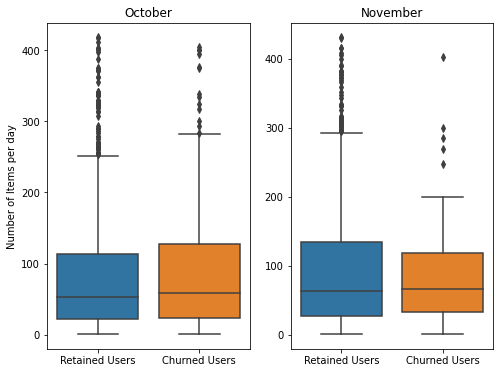

In [37]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('October')
sns.boxplot(data=items_per_day_all_oct);
plt.ylabel("Number of Items per day");
plt.subplot(1, 2, 2)
plt.title('November')
sns.boxplot(data=items_per_day_all_nov);

The distribution of the number of items per day between the two groups is not so different, the small differences such as the number of outliers present in the Retained Users group may be explained simply by the size of that group

In [38]:
# Counting the Ads of Retained Users
ads_in_weekday = train.filter((train.page == "Roll Advert") & (train.Churn == 0)) \
    .groupby(train.weekday).count().orderBy(train.weekday.cast("float"))
ads_in_weekday_pd = ads_in_weekday.toPandas()

# Counting the Ads of Churned Users
ads_in_weekday_churn = train.filter((train.page == "Roll Advert") & (train.Churn == 1)) \
    .groupby(train.weekday).count().orderBy(train.weekday.cast("float"))
ads_in_weekday_churn_pd = ads_in_weekday_churn.toPandas()

# Calculating percentages per day of the week
ads_in_weekday_pd['count'] = ads_in_weekday_pd['count']/train.filter(train.Churn==0).count()
ads_in_weekday_churn_pd['count'] = ads_in_weekday_churn_pd['count']/train.filter(train.Churn==1).count()

Let's now explore the number of Ads viewed by each group on each day of the week.

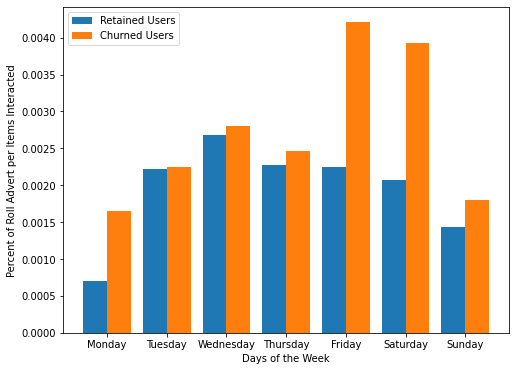

In [39]:
X = ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'] 
X_axis = np.arange(7)
plt.figure(figsize=(8, 6))
plt.bar(X_axis - 0.2, ads_in_weekday_pd['count'], 0.4, label = 'Retained Users')
plt.bar(X_axis + 0.2, ads_in_weekday_churn_pd['count'], 0.4, label = 'Churned Users')
plt.xticks(X_axis, X)
plt.xlabel("Days of the Week")
plt.ylabel("Percent of Roll Advert per Items Interacted")
plt.legend()
plt.show()

Notice that the number of Ads per number of items interacted is significantly higher on Friday and Saturday for Churned Users compared to Retained Users. Adding statistics per day of the week as features for the Machine Learning model might be a good idea.

Let's now compare the rate of Thumbs Up and Down of each group that we thought might be a good feature when we looked at the previous table.

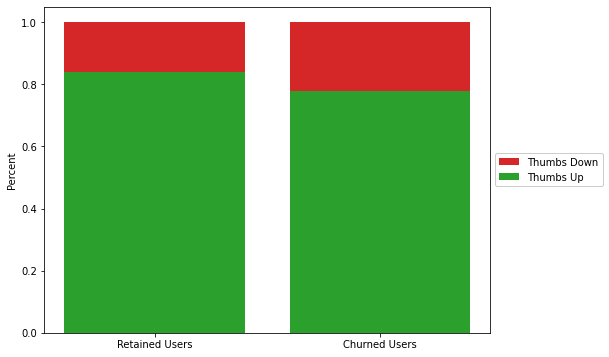

In [40]:
thumbs_table = train.filter((train.page == 'Thumbs Down') | (train.page == 'Thumbs Up')) \
    .select("page", "Churn")
thumbs_table = thumbs_table.toPandas()

user = [0, 1]
thumbs = ['Thumbs Up', 'Thumbs Down']
colors = ['C2', 'C3']

artists = [] # for storing references to plot elements
baselines = np.zeros(len(user))
user_counts = thumbs_table['Churn'].value_counts()

plt.figure(figsize=(8, 6))
# for each second-variable category:
for i, color in zip(range(len(thumbs)), colors):
    # isolate the counts of the first category,
    thumb = thumbs[i]
    inner_counts = thumbs_table[thumbs_table['page'] == thumb]['Churn'].value_counts()
    inner_props = inner_counts / user_counts
    # then plot those counts on top of the accumulated baseline
    bars = plt.bar(x = np.arange(len(user)),
                   height = inner_props[user],
                   bottom = baselines, 
                   color=color)
    artists.append(bars)
    baselines += inner_props[user]

plt.xticks(np.arange(len(user)), ['Retained Users', 'Churned Users'])
plt.legend(reversed(artists), reversed(thumbs), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6);
plt.ylabel("Percent");

Indeed, Churn Users have on average less Thumbs Up and more Thumbs Down than Retained Users.

### Calculating Statistics by Hour
How many songs do each of these groups listen to in a given hour?

Text(0, 0.5, 'Songs Played')

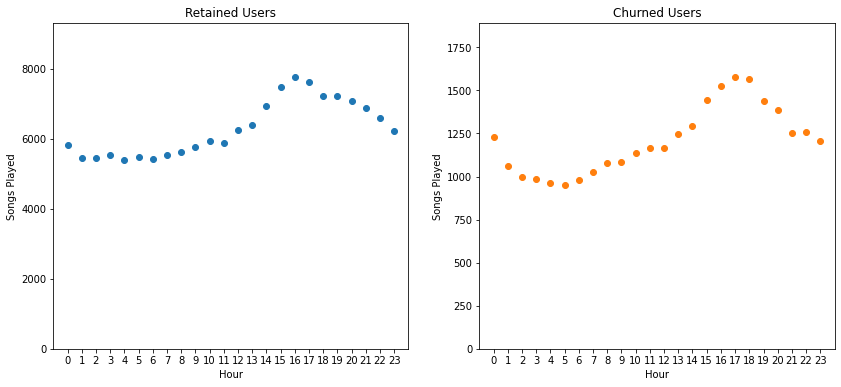

In [41]:
plt.figure(figsize=(14, 6))

# Counting the next song page requests
songs_in_hour = train.filter((train.page == "NextSong") & (train.Churn == 0)) \
    .groupby(train.hour).count().orderBy(train.hour.cast("float"))
songs_in_hour_pd = songs_in_hour.toPandas()

plt.subplot(1, 2, 1)
plt.title('Retained Users')
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * songs_in_hour_pd["count"].max())
plt.xlabel("Hour")
plt.ylabel("Songs Played");

# Counting the next song page requests
songs_in_hour_churn = train.filter((train.page == "NextSong") & (train.Churn == 1)) \
    .groupby(train.hour).count().orderBy(train.hour.cast("float"))
songs_in_hour_churn_pd = songs_in_hour_churn.toPandas()

plt.subplot(1, 2, 2)
plt.title('Churned Users')
plt.scatter(songs_in_hour_churn_pd["hour"], songs_in_hour_churn_pd["count"], color='C1')
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * songs_in_hour_churn_pd["count"].max())
plt.xlabel("Hour")
plt.ylabel("Songs Played")

We can see some trends in how many songs users played in different hours of the day, and the pattern doesn't look so different from Retained and Churned Users.

Lastly, before moving into feature engineering let's compare the number of songs listened by each group per session and between home page visits to see if we can find some differences.

In [42]:
n_songs = train.filter((train.Churn == 0) & (train.page == "NextSong")).count()
n_sessions = train.filter(train.Churn == 0).groupBy("userId", "sessionId").count().count()
n_songs_churn = train.filter((train.Churn == 1) & (train.page == "NextSong")).count()
n_sessions_churn = train.filter(train.Churn == 1).groupBy("userId", "sessionId").count().count()

In [43]:
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window.partitionBy('userID').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

cusum = train.filter((train.page == 'NextSong') | (train.page == 'Home')).select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))).withColumn('period', Fsum('homevisit').over(user_window))

df = cusum.filter((cusum.page == 'NextSong')).filter(train.Churn == 0).groupBy('userID', 'period') \
    .agg({'period':'count'}).agg({'count(period)':'avg'}).toPandas()
avg_songs_between_homepage = df.loc[0, 'avg(count(period))']

df_churn = cusum.filter((cusum.page == 'NextSong')).filter(train.Churn == 1).groupBy('userID', 'period') \
    .agg({'period':'count'}).agg({'count(period)':'avg'}).toPandas()
avg_songs_between_homepage_churn = df_churn.loc[0, 'avg(count(period))']

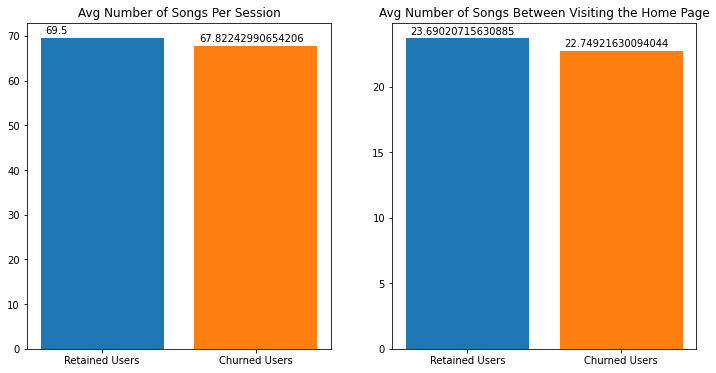

In [44]:
plt.figure(figsize=(12, 6));

plt.subplot(1, 2, 1)
plt.title('Avg Number of Songs Per Session');
plt.bar(x=['Retained Users', 'Churned Users'], height=[n_songs/n_sessions, n_songs_churn/n_sessions_churn], 
        color=['C0', 'C1']);

values = [n_songs/n_sessions, n_songs_churn/n_sessions_churn]

for index, value in enumerate(values):
    plt.text(index-0.37, value+1, str(value))

    
plt.subplot(1, 2, 2)
plt.title('Avg Number of Songs Between Visiting the Home Page');
plt.bar(x=['Retained Users', 'Churned Users'], height=[avg_songs_between_homepage, avg_songs_between_homepage_churn], 
        color=['C0', 'C1']);

values = [avg_songs_between_homepage, avg_songs_between_homepage_churn]

for index, value in enumerate(values):
    plt.text(index-0.37, value+0.3, str(value))

On average, Churned Users listen about 1 song less per session and between visiting the home page compared to Retained Users.

# Feature Engineering
Now that we are familiarized with the data, let's build out the features we found promising to train the model on.

As we saw in the previous histogram, the Retained Users listen to a higher number of artists than Churned Users, so let's add that feature to the dataframe we are going to train the ML models on.

In [45]:
df = user_log_valid.groupBy("userId", "artist").count().groupBy("userId").count().withColumnRenamed("count", "n_artists")
df.show()

+------+---------+
|userId|n_artists|
+------+---------+
|100010|      253|
|200002|      340|
|   125|        9|
|    51|     1386|
|   124|     2233|
|     7|      143|
|    15|     1303|
|    54|     1745|
|   155|      644|
|   132|     1300|
|   154|       79|
|100014|      234|
|   101|     1242|
|    11|      535|
|   138|     1333|
|300017|     2071|
|    29|     1805|
|    69|      866|
|100021|      208|
|    42|     2074|
+------+---------+
only showing top 20 rows



Let's also add the number of interactions each user has had with the service.

In [46]:
n_interactions = user_log_valid.select("userId").groupBy("userId").count().withColumnRenamed("count", "n_interactions")
n_interactions.show()

+------+--------------+
|userId|n_interactions|
+------+--------------+
|100010|           381|
|200002|           474|
|   125|            11|
|    51|          2464|
|   124|          4825|
|     7|           201|
|    54|          3437|
|    15|          2278|
|   155|          1002|
|   132|          2304|
|   154|           118|
|100014|           310|
|   101|          2149|
|    11|           848|
|   138|          2469|
|300017|          4428|
|    29|          3603|
|    69|          1342|
|100021|           319|
|    42|          4257|
+------+--------------+
only showing top 20 rows



In [47]:
df = df.join(n_interactions, "userId", "full")

The length column in the dataset refers to the length of each action in seconds. I think calculating summary statistics over this column for each user might contain insights that the model can learn from, for example, what is the mean, 25 percentile, or standard deviation of the actions in seconds the user performed.

In [48]:
df_length_st = user_log_valid.dropna(how="any", subset=["length"])
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_length_st = df_length_st.withColumn('length_avg', Favg('length').over(windowval))
df_length_st = df_length_st.withColumn('length_std', stddev_samp('length').over(windowval))
df_length_st = df_length_st.withColumn('length_min', min('length').over(windowval))
percentile_25 = expr("percentile_approx(length, 0.25)")
df_length_st = df_length_st.withColumn('length_25', percentile_25.over(windowval))
percentile_50 = expr("percentile_approx(length, 0.5)")
df_length_st = df_length_st.withColumn('length_med', percentile_50.over(windowval))
percentile_75 = expr("percentile_approx(length, 0.75)")
df_length_st = df_length_st.withColumn('length_75', percentile_75.over(windowval))
df_length_st = df_length_st.withColumn('length_max', max('length').over(windowval))
df_length_st = df_length_st.select("userId", "length_avg", "length_std", "length_min", "length_25", "length_med", "length_75", "length_max").dropDuplicates()
df_length_st.show()

+------+------------------+------------------+----------+---------+----------+---------+----------+
|userId|        length_avg|        length_std|length_min|length_25|length_med|length_75|length_max|
+------+------------------+------------------+----------+---------+----------+---------+----------+
|100010|  243.421444909091|  79.5156544698794|  52.27057|197.45914| 237.13914|277.15873| 538.85342|
|200002|242.91699209302305|   75.447490312729|  26.56608|198.03383| 237.26975|273.89342| 592.06485|
|   125|261.13913750000006|  78.1110647194169| 178.41587| 203.2322| 213.60281|323.81342| 391.26159|
|   124|248.17653659965674| 99.33044264553511|  18.05016|198.05995|  233.9522|277.52444|2369.04444|
|    51|247.88055082899118|104.57060972073867|   4.04853|198.76526| 235.20608|273.94567|2594.87302|
|     7| 253.5605806666668|109.42993284782153|   38.3473|201.79546| 232.61995|276.13995|   878.602|
|    15|249.37701452978064| 88.73888041148142|  21.91628| 200.9073| 235.25832| 280.0322| 1373.6224|


In [49]:
df = df.join(df_length_st, "userId", "full")

Since both paid and free users can cancel their accounts, Let's add a feature of the number of interactions a user had as a free and paid user.

In [50]:
level = user_log_valid.groupBy("userId").pivot("level").count()
level.show()

+------+----+----+
|userId|free|paid|
+------+----+----+
|200002| 120| 354|
|100010| 381|null|
|   125|  11|null|
|     7| 201|null|
|   124|null|4825|
|    51|null|2464|
|    54| 578|2859|
|    15|null|2278|
|   155| 144| 858|
|   132|  34|2270|
|   154| 118|null|
|100014|null| 310|
|    11| 619| 229|
|   101|  76|2073|
|300017|null|4428|
|   138| 262|2207|
|100021| 319|null|
|    29| 390|3213|
|    69|  39|1303|
|   112| 292|null|
+------+----+----+
only showing top 20 rows



In [51]:
df = df.join(level, "userId", "full")

Maybe the cohort of the users is related to whether they canceled their account or not. Let's include the timestamp of the time when the user got registered in the service.

In [52]:
registration = user_log_valid.select("userId", "registration").dropDuplicates()
registration.show()

+------+-------------+
|userId| registration|
+------+-------------+
|200024|1537897424000|
|200025|1532696273000|
|   118|1537893493000|
|    28|1537634865000|
|100003|1537309344000|
|   122|1535498705000|
|   149|1536980520000|
|   111|1536372490000|
|300001|1526739206000|
|     3|1533886191000|
|    62|1531804365000|
|100017|1533247234000|
|    10|1538159495000|
|200010|1537764007000|
|    40|1535525247000|
|   131|1533102330000|
|   136|1537034286000|
|    75|1537201808000|
|   128|1535269914000|
|200019|1537638755000|
+------+-------------+
only showing top 20 rows



In [53]:
df = df.join(registration, "userId", "full")

Because this subset of the data is just from two months, maybe the number of times the user opened the service is related to whether or not they'll cancel.

In [54]:
sessions = user_log_valid.select("userId", "sessionId").dropDuplicates().groupBy("userId").count().withColumnRenamed("count", "n_sessions")
sessions.show()

+------+----------+
|userId|n_sessions|
+------+----------+
|100010|         7|
|200002|         6|
|   125|         1|
|    51|        10|
|   124|        29|
|     7|         7|
|    54|        37|
|    15|        15|
|   155|         6|
|100014|         6|
|   132|        16|
|   154|         3|
|   101|        10|
|    11|        16|
|300017|        63|
|   138|        15|
|    29|        34|
|    69|         9|
|100021|         5|
|    42|        47|
+------+----------+
only showing top 20 rows



In [55]:
df = df.join(sessions, "userId", "full")

As we saw previously, calculating interactions per day of the week might be a good feature for the ML models.

In [56]:
user_log_valid = user_log_valid.withColumn("weekday", dayofweek(get_weekday(user_log_valid.ts)))
weekday_items = user_log_valid.groupBy("userId").pivot("weekday").count()
weekday_items.show()

+------+----+----+----+----+----+----+----+
|userId|   1|   2|   3|   4|   5|   6|   7|
+------+----+----+----+----+----+----+----+
|200002|null|  86|  96|null| 292|null|null|
|100010|null| 121|  55|  33|null| 112|  60|
|   125|null|null|null|null|null|  11|null|
|     7|null|null|  24| 133|   7|  37|null|
|   124| 373| 975|1000| 623| 599|1047| 208|
|    51| 107| 568| 526| 228| 343| 629|  63|
|    54| 393| 425| 369| 800| 705| 442| 303|
|    15| 209| 263| 520| 172| 416| 367| 331|
|   155|null|null| 156| 233|  81| 532|null|
|   132|  60| 389| 578| 471| 252| 468|  86|
|   154|null|null|  30|null|null|  24|  64|
|100014|null|null| 167|  57|null|  33|  53|
|   101| 137| 432| 581| 552| 273| 106|  68|
|    11|  62| 282|  70|  49|  68| 279|  38|
|300017| 495| 343| 847| 577| 711| 970| 485|
|   138|  80| 278| 293| 132| 727| 584| 375|
|    69|  87|  92| 388| 130| 261| 384|null|
|100021| 182|null|null|null|  14|  19| 104|
|    29| 194| 881| 732| 563| 827| 248| 158|
|   112|  28| 108|  24|  33|  45

In [57]:
df = df.join(weekday_items, "userId", "full")

Off course, we should also add to the features dataframe the count of each page the user interacted with.

In [58]:
page = user_log_valid.groupBy("userId").pivot("page").count()
page.show()

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|  null|                     null|        5| null|   2|  20|     5|     387|          7|         null|       3|            null|             1|          6|       21|      2|
|100010|    1|         4|              7|  null|                     null|     null| null|   2|  11|     5|     275|         52|         null|  

In [59]:
df = df.join(page, "userId", "full")

In [60]:
df = df.drop("Cancel", "Cancellation Confirmation")

I'm not sure if the gender is related to whether or not they'll canceled the service, but we can later rectify this by evaluating the features importance of the trained ML model.

In [61]:
gender = user_log_valid.select("userId", "gender").dropDuplicates()
flag_females = udf(lambda x: 1 if x == "F" else 0, IntegerType())
gender = gender.withColumn("is_female", flag_females("gender"))
gender = gender.drop("gender")
gender.show()

+------+---------+
|userId|is_female|
+------+---------+
|    44|        1|
|    46|        1|
|    41|        1|
|    72|        1|
|300023|        1|
|    39|        1|
|100010|        1|
|    40|        1|
|    94|        1|
|    35|        1|
|    75|        1|
|   116|        1|
|200001|        0|
|200020|        0|
|100008|        1|
|200015|        0|
|   100|        0|
|100006|        1|
|300005|        1|
|    25|        1|
+------+---------+
only showing top 20 rows



In [62]:
df = df.join(gender, "userId", "full")

Finally, let's add the labels.

In [63]:
train_labels = user_log_valid.select("userId", "Churn").dropDuplicates()
train_labels.show()

+------+-----+
|userId|Churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [64]:
df = df.join(train_labels, "userId", "full")

Because many of the features we added were not present for all users, some values are null. Let's replace those null values with zeros.

In [65]:
df = df.na.fill(value=0)

Perfect, let's look at the features we've built.

In [66]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- n_artists: long (nullable = true)
 |-- n_interactions: long (nullable = true)
 |-- length_avg: double (nullable = false)
 |-- length_std: double (nullable = false)
 |-- length_min: double (nullable = false)
 |-- length_25: double (nullable = false)
 |-- length_med: double (nullable = false)
 |-- length_75: double (nullable = false)
 |-- length_max: double (nullable = false)
 |-- free: long (nullable = true)
 |-- paid: long (nullable = true)
 |-- registration: long (nullable = true)
 |-- n_sessions: long (nullable = true)
 |-- 1: long (nullable = true)
 |-- 2: long (nullable = true)
 |-- 3: long (nullable = true)
 |-- 4: long (nullable = true)
 |-- 5: long (nullable = true)
 |-- 6: long (nullable = true)
 |-- 7: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: lon

In [67]:
# Vector assembled set of features 
inputCols = ["n_artists", "n_interactions", "length_avg", "length_std", "length_min", "length_25", "length_med", "length_75", 
 "length_max", "free", "paid", "registration", "n_sessions", "1", "2", "3", "4", "5", "6", "7", "About", "Add Friend", 
 "Add to Playlist", "Downgrade", "Error", "Help", "Home", "Logout", "NextSong", "Roll Advert", "Save Settings", 
 "Settings", 'Submit Downgrade', "Submit Upgrade", 'Thumbs Down', 'Thumbs Up', 'Upgrade', "is_female"]
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")

output = assembler.transform(df)

# Modeling
<p>Good enough. Now let's split the full dataset into train and test sets. Testing out several machine learning methods and evaluating the F1 score of the various models. We'll determine the winning model based on cross validation F1 score and report results on the test set. We'll use the F1 score as the metric to optimize because the users that canceled are a fairly small subset.</p>
<p>Because the data frame that we have built has features with very different scales, for example the "is_female" feature ranges from 0 to 1, while the "registration" feature has 13 digits. We are going to need to apply feature scaling, we'll use min-max scaling where values will end up ranging from 0 to 1.</p>

In [68]:
output_train = output.join(train_ids, on="userId", how="inner")
output_test = output.join(train_ids, on="userId", how="leftanti")

In [69]:
# Applying Standard Scaling to the assembled features 
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaledData_train = scaler.fit(output_train).transform(output_train)
scaledData_test = scaler.fit(output_test).transform(output_test)

In [70]:
train_data = scaledData_train.select(col("Churn").alias("label"), col("scaledFeatures").alias("features"))
test_data = scaledData_test.select(col("Churn").alias("label"), col("scaledFeatures").alias("features"))
train_data.head()

Row(label=0, features=DenseVector([0.0703, 0.039, 0.4333, 0.2955, 0.2233, 0.3147, 0.6719, 0.0077, 0.0969, 0.1867, 0.0, 0.6438, 0.0566, 0.0, 0.0832, 0.0345, 0.0233, 0.0, 0.0836, 0.0506, 0.04, 0.028, 0.0292, 0.0, 0.0, 0.0435, 0.031, 0.0403, 0.034, 0.4062, 0.0, 0.0, 0.0, 0.0, 0.0667, 0.0389, 0.1333, 1.0]))

<p>Now that we explored the data, sampled a training set and a test set, cleaned and prepared the data, we are now ready to select and train a Machine Learning model. We are going to user Cross-Validation to better evaluate the different models.</p>
<p>The CrossValidator function from Spark.ml expects an estimator (ml model), an estimatorParamMaps (object which is the grid of parameters to search from to find the best combination of parameters), and evaluator which is the metric that we want to evaluate.</p>
<p>Before diving deeper into a single Machine Learning algorithm, we are going to try out many models from various categories of Machine Learning algorithms without spending time tweaking the hyperparameters. The goal is to find the most promising model, which is why we need to define the estimatorParamMaps as an empty grid.</p>

In [71]:
grid = ParamGridBuilder().build()
evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [72]:
lr = LogisticRegression()
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
cvModel_lr = cv_lr.fit(train_data)
cvModel_lr.avgMetrics

[0.6512417890955713]

In [73]:
dt = DecisionTreeClassifier()
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator)
cvModel_dt = cv_dt.fit(train_data)
cvModel_dt.avgMetrics

[0.6703770140883117]

In [74]:
rf = RandomForestClassifier()
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator)
cvModel_rf = cv_rf.fit(train_data)
cvModel_rf.avgMetrics

[0.6784583298484219]

The most promising model appears to be the RandomForestClassifier, now we need to fine-tune it. We'll use random search to fine-tune the maxBins parameter because the search space is large. for the other two parameters we'll fine-tune using  a simple grid search.

In [75]:
bins = random.sample(range(10, 100), 3)
print(bins)
params_grid = ParamGridBuilder().addGrid(rf.maxDepth, [3,5,7]).addGrid(rf.maxBins, bins).build()

[27, 99, 41]


In [76]:
cv_rf_final = CrossValidator(estimator=rf, estimatorParamMaps=params_grid, evaluator=evaluator)
cvModel_rf_final = cv_rf_final.fit(train_data)

In [77]:
bestModel = cvModel_rf_final.bestModel

In [78]:
cvModel_rf.avgMetrics

[0.6784583298484219]

In [79]:
cvModel_rf_final.avgMetrics

[0.6818049956830338,
 0.6759801921649604,
 0.6743583354564952,
 0.6803006986766696,
 0.6720451195007854,
 0.6840581542253446,
 0.6933178390886117,
 0.6765821103772528,
 0.6922683237039253]

The final model has the following parameters.

In [80]:
bestModel._java_obj.getMaxDepth()

7

In [82]:
bestModel._java_obj.getMaxBins()

27

After tweaking the model for a while, now we have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set.

In [83]:
predictions = bestModel.transform(test_data)

In [84]:
f1 = evaluator.evaluate(predictions)
print("Test F1 score = %g " % (f1))

Test F1 score = 0.749426 


Not bad, can be much more improved but is a great starting point. Let's compare the results of the different parameters.

In [86]:
results = []
for n in range(len(cvModel_rf_final.avgMetrics)):
    params = list(cvModel_rf_final.getEstimatorParamMaps()[n].values())
    params.append(cvModel_rf_final.avgMetrics[n])
    results.append(params)
    
parameters_comp = pd.DataFrame(results, columns =['maxDepth', 'maxBins', 'F1 score'])
parameters_comp.sort_values("F1 score", ascending=False).reset_index(drop=True)

,maxDepth,maxBins,F1 score
0,7,27,0.693318
1,7,41,0.692268
2,5,41,0.684058
3,3,27,0.681805
4,5,27,0.680301
5,7,99,0.676582
6,3,99,0.675980
7,3,41,0.674358
8,5,99,0.672045


Finally, let's explore why that model performed best by looking at the feature importance of the model.

In [87]:
feature_importances = []
for importance, feature in zip(bestModel.featureImportances.toArray(), inputCols):
    combo = [importance, feature]
    feature_importances.append(combo)

features = pd.DataFrame(feature_importances, columns =['Importance', 'Feature'])
features.sort_values("Importance", ascending=False).reset_index(drop=True)

,Importance,Feature
0,0.068956,length_75
1,0.060978,Thumbs Down
2,0.048752,length_max
3,0.046062,n_artists
4,0.043503,free
5,0.042441,Add to Playlist
6,0.042062,length_avg
7,0.040906,length_med
8,0.040438,length_std
9,0.039564,Add Friend


The most important features for the best model were: the statistics we calculated about the lenght in seconds of each action the user performed in the service, the number of artists listened, and the number of Ads

If we want to further improve the model, we can do a wider search of the best combination of hyperparameters, and treat some of the feature preparation steps as hyperparameters. The grid search will automatically find out whether or not to add or remove features. We could also look at specific errors that the system makes, and then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, etc.).